In [32]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
import pickle

In [11]:
churn_df = pd.read_csv("../data/task_data_churned_clean.csv")

In [12]:
churn_df.columns

Index(['ws_users_activated', 'ws_users_deactivated', 'ws_users_invited',
       'action_create_project', 'action_export_report',
       'action_api_and_webhooks', 'action_time_entries_via_tracker',
       'action_start_trial', 'action_import_csv', 'action_create_invoice',
       'action_lock_entries', 'action_add_targets',
       'action_connect_quickbooks', 'action_create_expense',
       'action_project_budget', 'action_screenshots', 'country',
       'value_days_to_purchase', 'value_number_of_active_months',
       'value_transactions_number', 'value_regular_seats', 'value_kiosk_seats',
       'revenue', 'churned_status'],
      dtype='object')

## Column explanation

Let's now try to give reasoning what each column could tell us, while keeping in mind that this is time tracking software (SaaS) 

- `ws_users_activated` : How many users have activated account in a workspace, assuming the bigger the number this is more likely is that this client didn`t churn

- `ws_users_deactivated` : How many users have deactivated account in a workspace, assuming the bigger the number this is more likely is that this client did (dissatisfaction)

- `ws_users_invited` : How many users were invited but haven`t  joined workspace. We can conclude that if the number of invited people is big that the client won`t churn

- `action_create_project` : How many project have been created 

- `action_export_report`, : How many times has report been exported

- `action_api_and_webhooks` : /

- `action_time_entries_via_tracker`, : How much entries do we have. More entries, probably no churn.

- `action_start_trial`, : The client who is interested in trial could tell us that he likes the product and is exploring capabilties.

- `action_import_csv`, : Probably you can import entries as a csv, in similar fashion as they are exported.

- `action_create_invoice`, : How many times invoice has been created. We can conclude that if the number is big that the client is satisfied

- `action_lock_entries`, : How many times lock has happened. Bigger the number, probably more long term partnership, leading to no churn

- `action_add_targets`, : /

- `action_connect_quickbooks`, : /

- `action_create_expense`, : Similar to create invoice, but only for expenses/total amount to pay per invoice or something similar

-  `action_screenshots` : Does the client, and how often do they take the screenshot

- `action_project_budget`, : Budget for a project. Probably, bigger the budget, less likely that the churn status to be `yes`

- `country`, : Country where the client is coming from. This can

- `value_days_to_purchase`, : /

- `value_number_of_active_months`, : Number of months that client has been paying the software

- `value_transactions_number`, : This is probably transaction_id in some form, which doesn't tell us  a lot about the client behaviour

- `value_regular_seats`, : number of seats you can buy for your company. More seats, less likely that the churn status to be `yes` 

- `value_kiosk_seats`, : Similar to regular seats

- `revenue`, : Client's revenue. Similar to cases above.

- `churned_status` : Yes or No

# Feature importance 
Now we will try to see what is the feature importance for each of the columns using some of the traditional ways and proving/disproving our though process.

### Random Forest

In [28]:
X = churn_df.drop(['churned_status', 'country'], axis=1)  
y = churn_df['churned_status'] 

# Creating RFC
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the classifier to your data
rf_classifier.fit(X, y)

# Getting feature importances
feature_importances = rf_classifier.feature_importances_

# Creating df 
importance_df_rf = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

# Sorting by importance values in descending order
importance_df_rf = importance_df_rf.sort_values(by='Importance', ascending=False)

# Calculating the cumulative sum of feature importances
importance_df_rf['Cumulative Importance'] = importance_df_rf['Importance'].cumsum()

# Showing the results
importance_df_rf.head(20)

,Feature,Importance,Cumulative Importance
17,value_number_of_active_months,0.145594,0.145594
21,revenue,0.111818,0.257412
16,value_days_to_purchase,0.111112,0.368524
3,action_create_project,0.098713,0.467238
18,value_transactions_number,0.079445,0.546682
0,ws_users_activated,0.073335,0.620018
4,action_export_report,0.057515,0.677533
9,action_create_invoice,0.048881,0.726414
19,value_regular_seats,0.044422,0.770837
14,action_project_budget,0.044406,0.815243


#### Plot for feature importance 

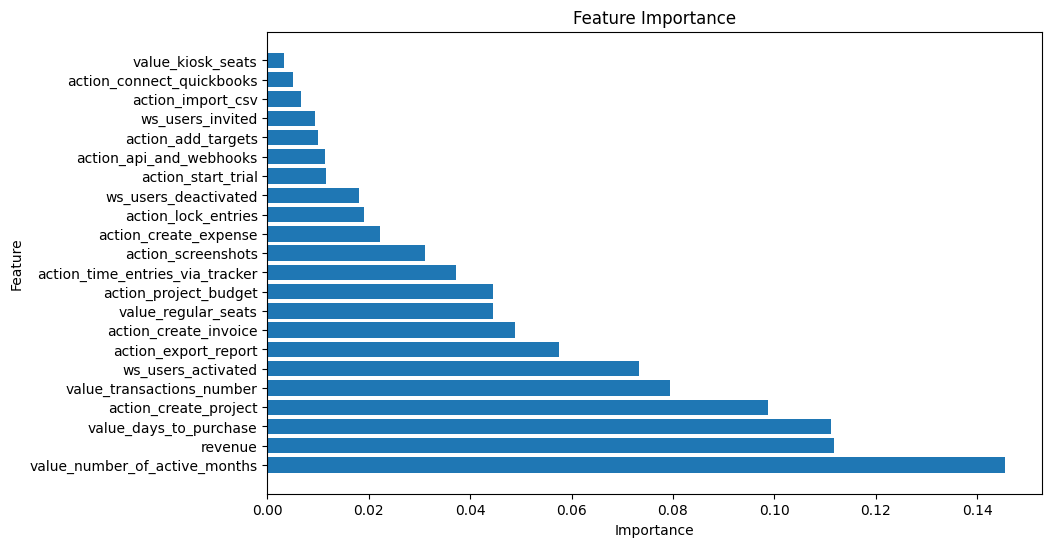

In [29]:
plt.figure(figsize=(10, 6))
plt.barh(importance_df_rf['Feature'], importance_df_rf['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()

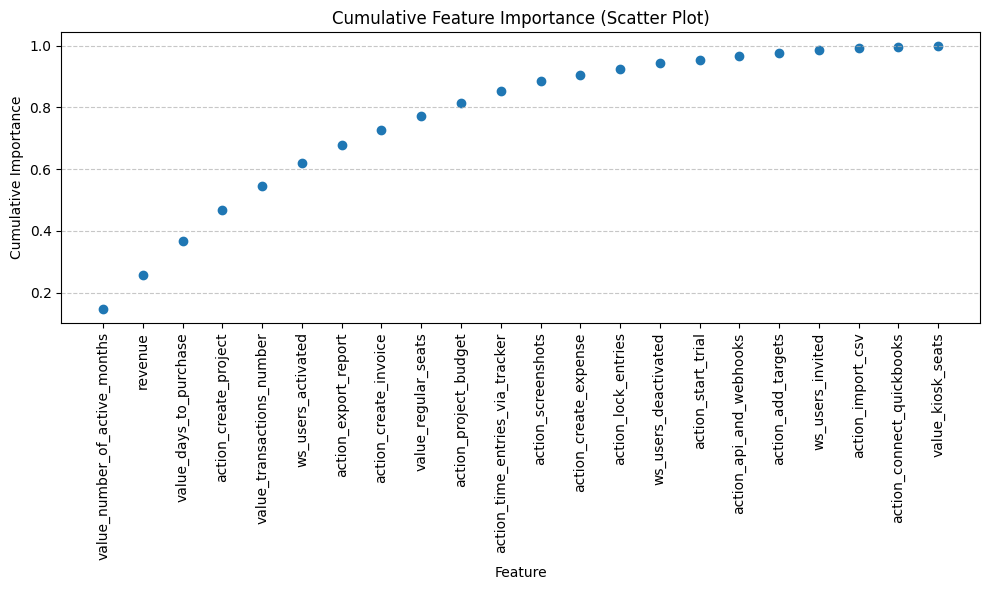

In [31]:
plt.figure(figsize=(10, 6))
plt.scatter(importance_df_rf['Feature'], importance_df_rf['Cumulative Importance'])
plt.xlabel('Feature')
plt.ylabel('Cumulative Importance')
plt.title('Cumulative Feature Importance (Scatter Plot)')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.grid(True, axis='y', linestyle='--', alpha=0.7)  # Add grid lines to the y-axis
plt.tight_layout()  # Ensure the labels fit within the figure
plt.show()

We can see here that 60% of confidence is only given by 6 features. And if we include top 10 most important ones, we are covering 80% of the important cases. So we will take top 12 features (just a small remark screenshots were 12, which we recognized as probably imporant in the first part of the task) that give us around 90% of importance and we will use those for model training.


In [43]:
top_12_features_with_target_column = list(importance_df_rf['Feature'][:12])
top_12_features_with_target_column.append("churned_status")
print(top_12_features_with_target_column)

['value_number_of_active_months', 'revenue', 'value_days_to_purchase', 'action_create_project', 'value_transactions_number', 'ws_users_activated', 'action_export_report', 'action_create_invoice', 'value_regular_seats', 'action_project_budget', 'action_time_entries_via_tracker', 'action_screenshots', 'churned_status']


In [44]:
len(top_12_features_with_target_column)

13

In [46]:
# Exporting the data with only top 12 most important features/columns
# along with target column
churn_df_filtered = churn_df[top_12_features_with_target_column]
churn_df_filtered.to_csv('../data/task_data_training.csv')
